In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

'/srv/mfs/hausserlab/fabio/data_analysis/notebooks'

In [2]:
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pickle
from src.CellsImage import CellsImage 
from src.utils.equations import color_mapper

In [81]:
%load_ext line_profiler
%load_ext heat

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The heat extension is already loaded. To reload it, use:
  %reload_ext heat


In [104]:
from functools import partial
import multiprocessing
from src.CellAbundance import CellAbundance
def site_generation(x, y, t, x_span, y_span, radius, grid_point): 
    x_center = (x_span[grid_point[0]+1] + x_span[grid_point[0]]) / 2
    y_center = (y_span[grid_point[1]+1] + y_span[grid_point[1]]) / 2
    idx = np.where((x - x_center) * (x - x_center) + (y - y_center) * (y - y_center) <= radius * radius)
    site = np.array([(x[i], y[i], t[i]) for i in idx])
    return site, grid_point

def get_segmentation_matrix_parallel(data, cell_types, pca_obj, archetype_obj, color_fun, h=800, w=800, radius=100, granularity=200):
    m = np.zeros((h, w, 3), dtype='uint8')
    x_span = np.arange(0, h+granularity, granularity)
    y_span = np.arange(0, w+granularity, granularity)

    y = data['x'].to_numpy()
    x = data['y'].to_numpy()
    t = data['cell_type'].to_numpy()

    mesh = np.array(np.meshgrid(range(len(x_span)-1), range(len(y_span)-1)))
    combinations = list(mesh.T.reshape(-1, 2))
    sites_pool = multiprocessing.Pool(20)
    f = partial(site_generation, x, y, t, x_span, y_span, radius)
    results = sites_pool.map(f, combinations)

    for site, grid_point in results:
        if len(site) > 0:
            counts = CellAbundance.calculate_cells_count(site, cell_types)
        else:
            counts = np.zeros(len(cell_types))
        new_pc = pca_obj.transform(counts.reshape(1, -1))
        _, alfa = archetype_obj.transform(new_pc[:, :3])
        color_submatrix = np.tile(color_fun(alfa[:, 0]), granularity*granularity).reshape(granularity, granularity, -1)
        m[x_span[grid_point[0]]:x_span[grid_point[0]+1], y_span[grid_point[1]]:y_span[grid_point[1]+1], :] = color_submatrix

    return m

patientID = 1
GRANULARITY = 25
CELL_TYPES = ['Kreatin-positive tumor', 'Treg', 'CD3-T', 'Neutrophils', 'Tumor', 'B', 
              'Macrophages', 'Mesenchymal-like', 'Other Immune', 'CD8-T', 'CD4-T', 
              'Undefined', 'Mono/Neu', 'DC/Mono', 'Endothelial', 'DC', 'NK']
cell_data = pd.read_csv("../../output/cell_positions_data/patient{}_cell_positions.csv".format(patientID))
with open("pca_3d", "rb") as f:
    pca_3d = pickle.load(f)

with open("AA_3D", "rb") as f:
    AA_3D = pickle.load(f)
color_vector = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]]).T
color_fun = partial(color_mapper, color_vector)
%lprun -f get_segmentation_matrix_parallel get_segmentation_matrix_parallel(cell_data, CELL_TYPES, pca_3d, AA_3D, color_fun, h=800, w=800, radius=100, granularity=200)


In [15]:
granularity = 25
alfa = np.random.rand(3, 1)

In [18]:
%%timeit
color_submatrix = np.array([[color_fun(alfa[:, 0]) for _ in range(granularity)] for _ in range(granularity)])

10.1 ms ± 45.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%%timeit
color_submatrix = np.tile(color_fun(alfa[:, 0]), 25*25).reshape(25, 25, -1)
#color_submatrix.sha

23.4 µs ± 255 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [99]:
from src.CellAbundance import CellAbundance
def site_generation(x, y, t, x_span, y_span, radius, grid_point): 
    x_center = (x_span[grid_point[0]+1] + x_span[grid_point[0]]) / 2
    y_center = (y_span[grid_point[1]+1] + y_span[grid_point[1]]) / 2
    idx = np.where((x - x_center) * (x - x_center) + (y - y_center) * (y - y_center) <= radius * radius)
    site = [(x[i], y[i], t[i]) for i in idx]
    return site, grid_point

CELL_TYPES = ['Kreatin-positive tumor', 'Treg', 'CD3-T', 'Neutrophils', 'Tumor', 'B', 
              'Macrophages', 'Mesenchymal-like', 'Other Immune', 'CD8-T', 'CD4-T', 
              'Undefined', 'Mono/Neu', 'DC/Mono', 'Endothelial', 'DC', 'NK']
x = np.random.randint(800, size=1000)
y = np.random.randint(800, size=1000)
x_span = np.arange(0, 825, 25)
y_span = np.arange(0, 825, 25)
t = np.random.choice(CELL_TYPES, 1000)
radius = 100
mesh = np.array(np.meshgrid(range(len(x_span)-1), range(len(y_span)-1)))
grid_point = list(mesh.T.reshape(-1, 2))[200]
%lprun -f site_generation site_generation(x, y, t, x_span, y_span, radius, grid_point)

In [100]:
%%timeit
s, g = site_generation(x, y, t, x_span, y_span, radius, grid_point)

22.5 µs ± 83.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


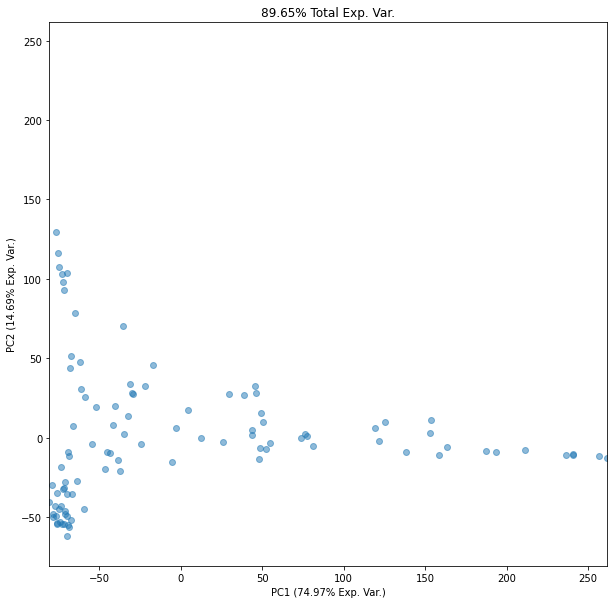

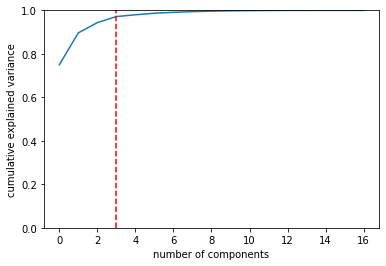

In [6]:
from src.CellAbundance import CellAbundance, generate_abundance_matrix
from src.utils.visualization import plot_scatter_pca, plot_cumulative_explained_variance, plot_PCAs, plot_CVEs
N_SITE = 100
PATIENT_ID = 4
RADIUS = 100
CELL_TYPES = ['Kreatin-positive tumor', 'Treg', 'CD3-T', 'Neutrophils', 'Tumor', 'B', 
              'Macrophages', 'Mesenchymal-like', 'Other Immune', 'CD8-T', 'CD4-T', 
              'Undefined', 'Mono/Neu', 'DC/Mono', 'Endothelial', 'DC', 'NK']
METHOD = 'abs'
PCA_SCALED = False 

cell_ab = CellAbundance(PATIENT_ID, N_SITE, RADIUS, CELL_TYPES, method=METHOD)
pc = cell_ab.perform_PCA(scale=PCA_SCALED)
plot_scatter_pca(pc, cell_ab.pca.explained_variance_ratio_)
plot_cumulative_explained_variance(cell_ab.pca.explained_variance_ratio_)

In [9]:
%%timeit
cell_ab = CellAbundance(PATIENT_ID, N_SITE, RADIUS, CELL_TYPES, method=METHOD)

25.8 ms ± 740 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%load_ext line_profiler
%load_ext heat

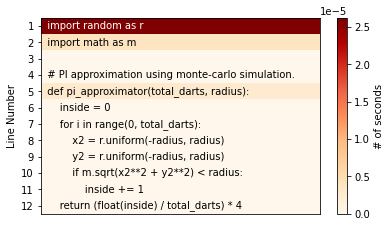

In [53]:
%%heat
import random as r
import math as m

# PI approximation using monte-carlo simulation.
def pi_approximator(total_darts, radius):
    inside = 0
    for i in range(0, total_darts):
        x2 = r.uniform(-radius, radius)
        y2 = r.uniform(-radius, radius)
        if m.sqrt(x2**2 + y2**2) < radius:
            inside += 1
    return (float(inside) / total_darts) * 4

In [54]:
%%timeit
pi_approximator(100000, 10)

82.3 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
%lprun -f pi_approximator pi_approximator(100000, 10)

In [29]:
%%timeit
pi_approximator(100000, 10)

81.4 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


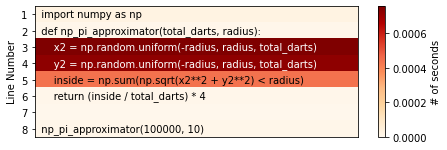

In [52]:
%%heat
import numpy as np
def np_pi_approximator(total_darts, radius):
    x2 = np.random.uniform(-radius, radius, total_darts)
    y2 = np.random.uniform(-radius, radius, total_darts)
    inside = np.sum(np.sqrt(x2**2 + y2**2) < radius)
    return (inside / total_darts) * 4

np_pi_approximator(100000, 10)

In [55]:
%%timeit
np_pi_approximator(100000, 10)

1.77 ms ± 2.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
